In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
tweet = pd.read_csv('https://raw.githubusercontent.com/jenhuluck/NLP_projects/main/disaster%20tweets%20classification/twitter_disaster_train.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Exploratory Data Analysis**

In [6]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 60

Target class distribution

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or not real disaster tweet')

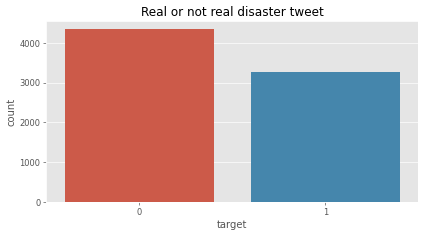

In [7]:
sns.countplot('target', data=tweet)
plt.title('Real or not real disaster tweet')

In [8]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

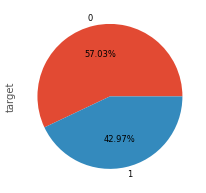

In [9]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [10]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-0szr1w1k
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-0szr1w1k
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp36-none-any.whl size=11742 sha256=b81c0751b8f32a207f6bc90a5f8331f3e1f8c55e807a8c51215e10bf720a4197
  Stored in directory: /tmp/pip-ephem-wheel-cache-mr28u9ps/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [11]:
import preprocess_kgptalkie as kgp

In [12]:
tweet = kgp.get_basic_features(tweet)

In [13]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


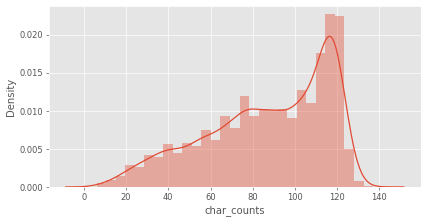

In [14]:
sns.distplot(tweet['char_counts'])

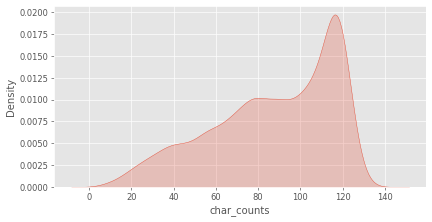

In [15]:
sns.kdeplot(tweet['char_counts'],shade=True)

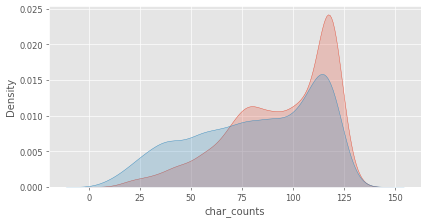

In [16]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'],shade=True)
sns.kdeplot(tweet[tweet['target']==0]['char_counts'],shade=True)

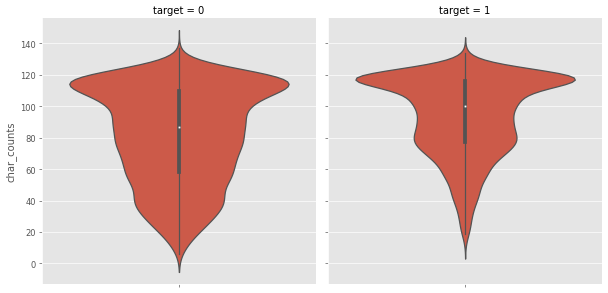

In [17]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

In [18]:
tweet

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


In [19]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

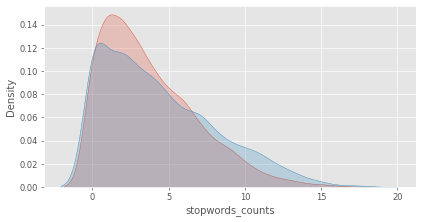

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'],shade=True)
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'],shade=True)

Most and Leaset Common Words

In [21]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [22]:
top20 = freqs[:20]

<BarContainer object of 20 artists>

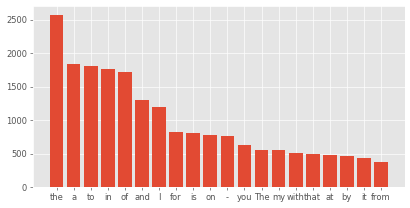

In [23]:
plt.bar(top20.index,top20.values)

In [24]:
least20 = freqs[-20:]

In [25]:
bi_gram = kgp.get_ngram(tweet,'text',ngram_range=2)

In [26]:
bi_gram[:20]

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476)]

One-Shot Data Clearning

In [27]:
def get_clean(x):
  x = str(x).lower().replace('\\',' ').replace('_',' ').replace('.', ' ')
  x = kgp.cont_exp(x)
  x = kgp.remove_emails(x)
  x = kgp.remove_urls(x)
  x = kgp.remove_html_tags(x)
  x = kgp.remove_rt(x)
  x = kgp.remove_accented_chars(x)
  x = kgp.remove_special_chars(x)
  x = kgp.remove_dups_char(x)
  return x


In [28]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [29]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0


In [30]:
kgp.get_ngram(tweet, 'text', ngram_range=2)

[('zxathetis are', 67861),
 ('zurich for', 67860),
 ('zumiez is', 67859),
 ('zss vs', 67858),
 ('zourryart forgot', 67857),
 ('zouma just', 67856),
 ('zouma has', 67855),
 ('zotar50 skeleton', 67854),
 ('zoom in', 67853),
 ('zonewolf123 liked', 67852),
 ('zonesthank god', 67851),
 ('zones donuat', 67850),
 ('zone with', 67849),
 ('zone what', 67848),
 ('zone war', 67847),
 ('zone they', 67846),
 ('zone protectdenaliwolves', 67845),
 ('zone outside', 67844),
 ('zone of', 67843),
 ('zone my', 67842),
 ('zone littlewomenla', 67841),
 ('zone laugh', 67840),
 ('zone johnny', 67839),
 ('zone in', 67838),
 ('zone httpt', 67837),
 ('zone during', 67836),
 ('zone common', 67835),
 ('zone coming', 67834),
 ('zone but', 67833),
 ('zone and', 67832),
 ('zone amirite', 67831),
 ('zombies take', 67830),
 ('zombie fun', 67829),
 ('zombie feel', 67828),
 ('zombie apocalypse', 67827),
 ('zomatoaus lovefood', 67826),
 ('zojadelin you', 67825),
 ('zodiac girl', 67824),
 ('ziuw httpt', 67823),
 ('zippolin

Disaster Words Visulization with Word Cloud

In [31]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via an disaster were be people california suicide no has police who when but been like killed do will 2 just hiroshima so than out fires storm crash families we train about now into s emergency your buildings bomb all there two what mh370 attack nuclear they am video wildfire accident get one bombing new minister northern burning prime how legionnaires dead me bomber some if homes car war atomic still obama fatal he years off may forest collapse us debris city retweet watch today first japan 1 malaysia latest man or mass near water severe had confirmed before those earthquake would found oil army spill world 70 floods down warning home under evacuation 3 outbreak 4 injured could derailment weather wreckage being saudi 40 thunderstorm migrants our old during flooding flood investigators say missing can their time bridge death her back mosque suspect state kil

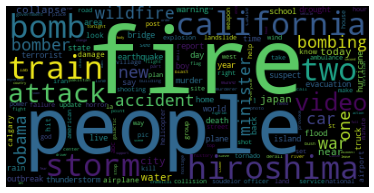

In [32]:
word_cloud = WordCloud(max_font_size = 100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

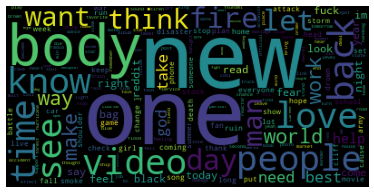

In [33]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size = 100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Classification with TFIDF

In [34]:
text = tweet['text']
y = tweet['target']

In [35]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [36]:
X.shape

(7613, 22545)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [38]:
def run_SVM(clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [39]:
from sklearn.svm import LinearSVC

In [40]:
clf = LinearSVC()
run_SVM(clf, X_train, y_train, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



Classification with TFIDF and SVM

In [41]:
! python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [42]:
import spacy


In [43]:
import en_core_web_lg
nlp = en_core_web_lg.load()


In [44]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [45]:
tweet['vec'] = tweet['text'].apply(lambda x:get_vec(x))

In [46]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1,1)

In [47]:
X.shape

(7613, 1)

In [48]:
X = np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)

In [49]:
X.shape

(7613, 300)

In [50]:
y = tweet['target']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [52]:
print(X_train.shape,
X_test.shape,
y_train.shape,
y_test.shape)

(6090, 300) (1523, 300) (6090,) (1523,)


In [53]:
clf = LinearSVC()
run_SVM(clf, X_train, y_train, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [55]:
token = Tokenizer()
token.fit_on_texts(text)

In [56]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [57]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [58]:
encoded_text = token.texts_to_sequences(text)

In [59]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [60]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [61]:
print(X.shape)

(7613, 40)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [63]:
print(vocab_size,max_length)

22581 40


In [64]:
vec_size = 100
model = Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=max_length))
model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2258100   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [66]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 7s 25ms/step - loss: 0.6751 - accuracy: 0.5814 - val_loss: 0.5643 - val_accuracy: 0.7452
Epoch 2/5
191/191 [==============================] - 4s 23ms/step - loss: 0.4943 - accuracy: 0.7838 - val_loss: 0.4580 - val_accuracy: 0.8063
Epoch 3/5
191/191 [==============================] - 4s 23ms/step - loss: 0.3084 - accuracy: 0.8742 - val_loss: 0.4716 - val_accuracy: 0.7945
Epoch 4/5
191/191 [==============================] - 4s 23ms/step - loss: 0.1765 - accuracy: 0.9373 - val_loss: 0.5179 - val_accuracy: 0.7754
Epoch 5/5
191/191 [==============================] - 4s 22ms/step - loss: 0.1150 - accuracy: 0.9616 - val_loss: 0.5502 - val_accuracy: 0.7649
CPU times: user 34.5 s, sys: 2.51 s, total: 37 s
Wall time: 24.4 s


In [67]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [68]:
x = 'Damage to school bus on 80 in multi car crash'
vec = get_encoded(x)

In [69]:
vec

array([[ 241,    5,  189,  392,   12, 2346,    4, 4497,  126,   87,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [70]:
np.argmax(model.predict(vec), axis=-1)

array([0])

BERT Model Building and Training

In [71]:
!pip install ktrain

In [72]:
from ktrain import text
import ktrain

In [73]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [74]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [75]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [76]:
learner.fit_onecycle(lr = 2e-5, epochs=5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
108/108 [==============================] - 102s 779ms/step - loss: 0.6343 - accuracy: 0.6177 - val_loss: 0.4122 - val_accuracy: 0.8360
Epoch 2/5
108/108 [==============================] - 80s 740ms/step - loss: 0.3924 - accuracy: 0.8315 - val_loss: 0.3846 - val_accuracy: 0.8451
Epoch 3/5
108/108 [==============================] - 80s 741ms/step - loss: 0.3255 - accuracy: 0.8597 - val_loss: 0.4218 - val_accuracy: 0.8425
Epoch 4/5
108/108 [==============================] - 80s 743ms/step - loss: 0.2272 - accuracy: 0.9097 - val_loss: 0.5040 - val_accuracy: 0.8320
Epoch 5/5
108/108 [==============================] - 80s 740ms/step - loss: 0.1548 - accuracy: 0.9448 - val_loss: 0.5427 - val_accuracy: 0.8202


In [77]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [78]:
data = 'i got today car accident, i am injured'

In [79]:
predictor.predict(data)

'target'

In [81]:
y_pred = predictor.predict(data)
classes = predictor.get_classes()
classes.index(y_pred)

1